# Introduction to Gaussian Process Regression
##### Author: Rodrigo Calderón (calderon@kasi.re.kr)


Useful resources:
* The bible for GP: [Rasmussen &  Williams](http://gaussianprocess.org/gpml/chapters/RW.pdf)
* Excellent blogpost with animations & explanations : [A visual exploration of GP](https://distill.pub/2019/visual-exploration-gaussian-processes/)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font',size=16,family='sans-serif')
plt.rc('text',usetex=True)

### **I - Notations**


"*A Gaussian Process (GP) is an infinite collection of random variables, any finite subset of which follows a (joint) multivariate Gaussian distribution.*"

$y(x)\sim\mathcal{GP}\left(\bar{f}=0,\;K=k(\sigma_f,\ell_f )\right)$, 

where :
* $y\sim \mathcal{GP}$ reads "the function $y(x)$ follows a multivariate Gaussian distribution"
* $\bar{f}$ is called the (prior) mean function
* $K$ is the (prior) covariance function, or "kernel"


For simplicity, we denote any quantity $F_\star=F(x_\star)$ and $F_{\star\star}=F(x_\star,x_\star)$ where $x_\star$ usually denotes an array of 'test values', where the predictions are to be computed.


### **II - The Kernel (Covariance Function)**
Exponential-Squared : $k(x_1,x_2;\sigma_f,\ell_f)=\sigma_f^2\,e^{-\frac{(x_1-x_2)^2}{2\ell_f^2}}$

In [3]:
def ExpSquaredKernel(x1,x2,sigma_f,ell_f):
    sqdist = np.sum(x1**2,1).reshape(-1,1) + np.sum(x2**2,1) - 2*np.dot(x1, x2.T)
    return sigma_f**2 * np.exp(-.5 * (1/ell_f**2) * sqdist)

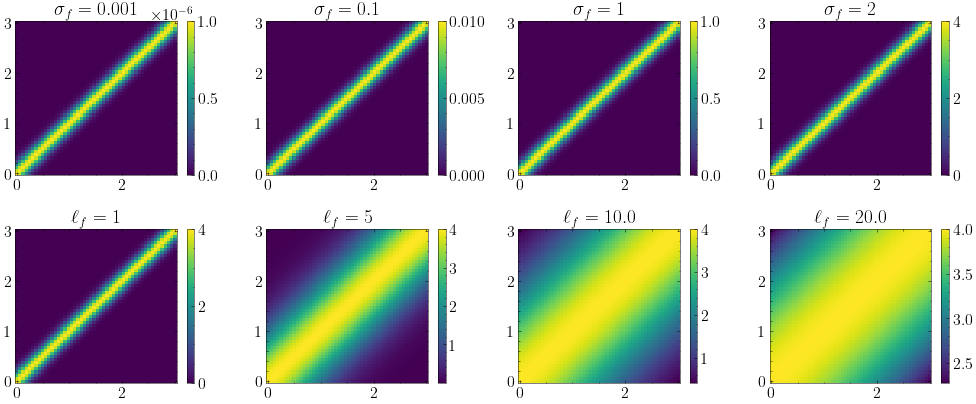

In [4]:
_=np.linspace(0,3)
XX,YY=np.meshgrid(_,_)

ells=[1,5,10.,20.]
sigmas=[0.001,0.1,1,2]

fig,axes=plt.subplots(2,len(sigmas),figsize=(3.5*len(sigmas),6))
axs=axes[0,:]

for i,sigma in enumerate(sigmas):
    axs[i].set_title(f'$\sigma_f={sigma}$')
    cs=axs[i].pcolormesh(XX,YY,ExpSquaredKernel(XX.T,YY,sigma,1))
    plt.colorbar(cs,ax=axs[i])
    
axs=axes[1,:]
for i,ell in enumerate(ells):
    axs[i].set_title(f'$\ell_f={ell}$')
    cs=axs[i].pcolormesh(XX,YY,ExpSquaredKernel(XX.T,YY,sigma,ell))
    plt.colorbar(cs,ax=axs[i])
    
fig.tight_layout()

**Bonus**: Try implementing a different kernel (e.g. Matern-5/2)

### **III - The Data**

In [5]:
def generate_data(f,N=20,seed=1234):
    if seed is not None:
        np.random.seed(seed)
    
    x=np.linspace(0.1,10,N)*np.random.rand(N)
    cov=np.random.rand(N)*0.1*np.eye(N)
    y=np.random.multivariate_normal(f(x),cov)

    return x,y,np.diag(np.sqrt(cov))

truth=lambda x: np.sin(x)*np.log(x)

In [6]:
# Prior mean function describing our measurements
prior_mean = 0.

# Get the data as "training points" for our GP
train_x,train_y,sigma_y=generate_data(truth,N=12)

# Assume uncorrelated measurements and construct diagonal covariance matrix
covmat=sigma_y**2*np.eye(len(train_x))

<ErrorbarContainer object of 3 artists>

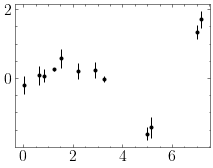

In [18]:
plt.errorbar(train_x,train_y,sigma_y,fmt='.k')

### **IV - The posterior mean and covariance**


We can compute the mean of the posterior distribution at a set of points $\mathbf{x_\star}$, using 
$\mathbf{\mu}= \mathbf{m}_\star+ \mathbf{K_\star}\mathbf{K}^{-1}(\mathbf{y}-\mathbf{m})$

The posterior covariance can be analytically be obtained using
$\mathbf{C}=\mathbf{K}_{\star\star}-\mathbf{K}_\star\mathbf{K}^{-1}\mathbf{K}^{T}_{\star}$

Further reading: See also Eq. (2.23) and (2.24) in [Chapter 2](http://gaussianprocess.org/gpml/chapters/RW.pdf) of Rasmussen & Williams

In [8]:
def predict(x_star,sigma_f,ell_f,covariance=False):
    """Compute the predictions at an array of x-values (x_star) for a set of hyperparameters (sigma_f,ell_f)

    Args:
        x_star (array): Array of values where to compute the GP predictions
        sigma_f (float): Amplitude of the deviations from the prior mean function
        ell_f (float): Typical correlation length
        covariance (bool, optional): Whether to  return the full posterior covariance (True), or simply the diagonal part (False). Defaults to True.

    Returns:
        tuple: the posterior mean and covariance (or its diagonal if covariance=False)
    """
    # Residual vector
    residual = train_y - prior_mean
    
    x_star=x_star.reshape(-1,1)
    
    # Compute covariance at test and training points
    K = ExpSquaredKernel(train_x.reshape(-1,1),train_x.reshape(-1,1),sigma_f,ell_f) + covmat
    K_star = ExpSquaredKernel(train_x.reshape(-1,1), x_star, sigma_f, ell_f)
    K_star_star = ExpSquaredKernel(x_star, x_star, sigma_f, ell_f)
    
    # Compute the Cholesky factor for the full covariance 
    L=np.linalg.cholesky(K)
    
    # Solve linear system rather than a matrix inversion
    v=np.linalg.solve(L, K_star)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, residual))

    # Compute mean and covariance of the posterior distributions
    posterior_mean = prior_mean + K_star.T@alpha
    posterior_covariance = K_star_star - v.T@v
    
    if covariance:
        return posterior_mean, posterior_covariance
    return posterior_mean, posterior_covariance.diagonal()

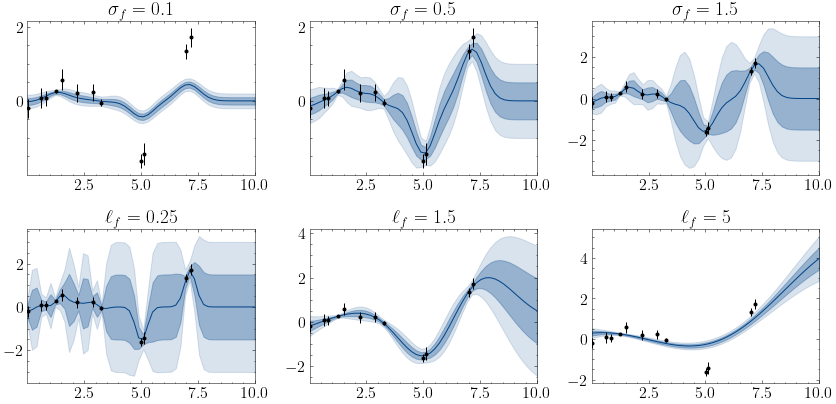

In [24]:
xpred=np.linspace(1e-3,10)

fig,axes=plt.subplots(2,3,figsize=(3*len(sigmas),6))
axs=axes[0,:]
for ax,sigma_f in zip(axs,[0.1,0.5,1.5]):
    # Compute predictions for each sigma_f
    mean,var=predict(xpred,sigma_f,0.5)
    std=var**0.5
    
    # Plot the predictions
    ax.set_title(f'$\{sigma_f=}$')
    ax.plot(xpred,mean,c='C0')
    ax.errorbar(train_x,train_y,sigma_y,fmt='.k')
    ax.set_xlim(xpred.min(),xpred.max())
    _=[ax.fill_between(xpred,mean-i*std,mean+i*std,alpha=0.3/i,color='C0') for i in [1,2]]
    

axs=axes[1,:]
for ax,ell_f in zip(axs,[0.25,1.5,5]):
    # Compute predictions for each sigma_f
    mean,var=predict(xpred,sigma_f,ell_f)
    std=var**0.5
    
    # Plot the predictions
    ax.set_title(f'$\{ell_f=}$') 
    ax.plot(xpred,mean,c='C0')
    ax.errorbar(train_x,train_y,sigma_y,fmt='.k')
    ax.set_xlim(xpred.min(),xpred.max())
    _=[ax.fill_between(xpred,mean-i*std,mean+i*std,alpha=0.3/i,color='C0') for i in [1,2]]

plt.tight_layout()

**Note**: All GP-related operations amounts to taking the inverse of the matrix $\mathbf{K}$! 

Computational cost $t\sim \mathcal{O}(N^3)$ where $N$ is the number of datapoints

### **V - The log-marginal likelihood (LML)**
The LML (or evidence) is given by

$$\ln\mathcal{L}=-\frac12\big[\mathbf{r}^{T}\,\mathbf{K}^
    {-1}\,\mathbf{r}+\ln{|\mathbf{K}|} + N\ln{(2\pi)}\big] $$

where :
* $\mathbf{r}^{T}\,\mathbf{K}^
    {-1}\,\mathbf{r}$ is analogous to the usual $\chi^2$ term, except $\mathbf{K}=\Sigma+k(\sigma_f,\ell_f)$, where $\Sigma$ is the data covariance
* $ \ln{|\mathbf{K}|}$ is a penalty term for very small $\ell_f$ (large number of effective degrees of freedom, # d.o.f  $\propto1/\ell_f$ )
* $N\ln{(2\pi)}$ is a just a constant and $N$ is the number of data points

The hyperparameters $(\sigma_f,\ell_f)$ are usual optimized such that the LML is maximized!

In [10]:
def LML(sigma_f,ell_f,individual_terms=False):      
    """
    Log-marginal likelihood under a GP. Implementation of Eq. (2.29)  in Rasmussen & Williams

    Args:
        sigma_f (float): Amplitude of the deviations from the mean function 
        ell_f (float): Typical correlation length for the kernel
        individual_terms (bool, optional): Whether to return individual terms contributing to the LML. Defaults to False.

    Returns:
        float: The log-marginal likelihood for a given set of hyperparameters
        tuple: if individual_terms=True, returns a tuple with the individual contributions to the LML
    """
    N = len(train_y)
    
    residual = train_y - prior_mean
    K = ExpSquaredKernel(train_x.reshape(-1,1),train_x.reshape(-1,1),sigma_f,ell_f) + covmat
    
    L = np.linalg.cholesky(K)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, residual))
    
    const=N*np.log(2*np.pi)
    chi2 = residual.T@alpha
    penalty=2*np.sum(np.log(np.diag(L)))
    
    if individual_terms:
        return -0.5*chi2,-0.5*penalty,-0.5*const
    
    return -0.5*(const + penalty + chi2)

Exercise: Plot the LML as a function of $\ell_f$ (for given $\sigma_f$) and inspect the individual contributions to the LML

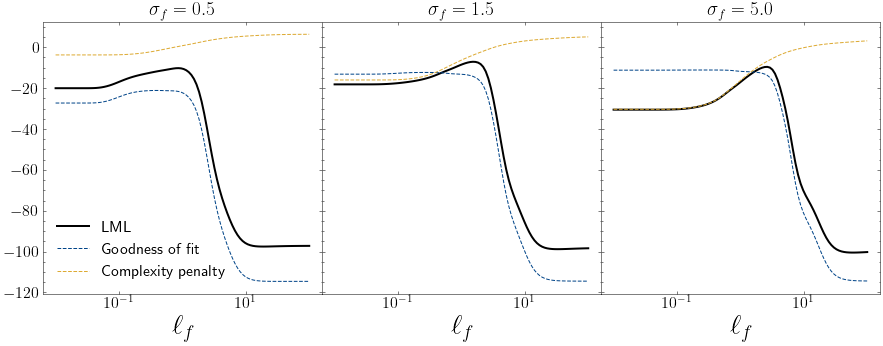

In [30]:
ells=np.logspace(-2,2.,100)  
fig,axs=plt.subplots(1,3,figsize=(15,5),sharey=True,gridspec_kw={'wspace':0})
for ax,sigma_f in zip(axs,[0.5,1.5,5]):  
    ax.set_title(f'$\{sigma_f=:.1f}$')
    ax.semilogx(ells,[LML(sigma_f,ell) for ell in ells],ls='-',c='k',lw=2.,label='LML')
    ax.semilogx(ells,[LML(sigma_f,ell,individual_terms=True)[0]+LML(sigma_f,ell,individual_terms=True)[2] for ell in ells],ls='--',label=r'Goodness of fit')
    ax.semilogx(ells,[LML(sigma_f,ell,individual_terms=True)[1]+LML(sigma_f,ell,individual_terms=True)[2] for ell in ells],ls='--',label='Complexity penalty')
    ax.set_xlabel(r'$\ell_f$',fontsize='xx-large')
axs[0].legend(loc='lower left')

In [12]:
from scipy.optimize import minimize

bf=minimize(lambda theta: -LML(*theta),[.5,.5]).x
bf

array([1.10390994, 1.3012595 ])

Having optimized the values of the hyperparameters $(\sigma_f,\ell_f)$, we can now get much more accurate predictions!

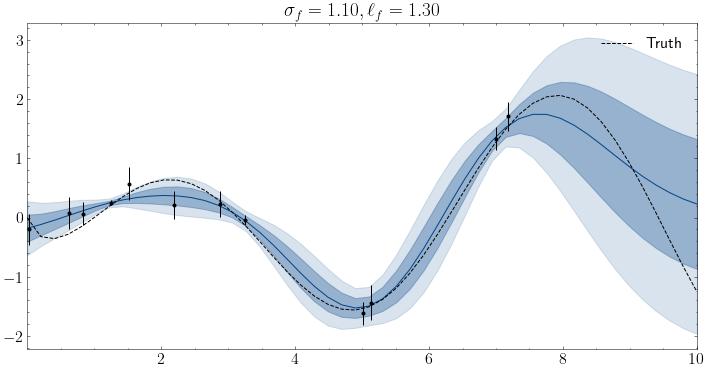

In [29]:
# Compute predictions for each sigma_f
mean,var=predict(xpred,*bf)
std=var**0.5

# Plot the predictions
plt.figure(figsize=(12,6))
plt.title(f'$\sigma_f={bf[0]:.2f},\ell_f={bf[1]:.2f}$')
plt.plot(xpred,mean,c='C0')
plt.plot(xpred,truth(xpred),'--k',label='Truth')
plt.errorbar(train_x,train_y,sigma_y,fmt='.k')
plt.xlim(xpred.min(),xpred.max())
_=[plt.fill_between(xpred,mean-i*std,mean+i*std,alpha=0.3/i,color='C0') for i in [1,2]]
plt.legend()

### **VI - Further reading**


For applications in Cosmology:

* Holsclaw et al 2010 - [Nonparametric Reconstruction of the Dark Energy Equation of State](https://arxiv.org/abs/1009.5443)
* Shafieloo, Kim, Linder 2012 - [Gaussian Process Cosmography](https://arxiv.org/abs/1204.2272)
* Calderon, L'Huillier, Polarski, Shafieloo & Starobinsky
 [Joint reconstructions of growth and expansion histories from Stage-IV surveys with
minimal assumptions I: Dark Energy beyond $\Lambda$](https://arxiv.org/abs/2206.13820)